<a href="https://colab.research.google.com/github/zayasinha/Tesla-Sales-Analytics-System/blob/main/Tesla_Sales_Analytics_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import os
from datetime import datetime
from typing import Dict, Any, List
from dataclasses import dataclass


In [ ]:
@dataclass
class PathConfig:
  RAW_DATA_PATH: str = "data/raw"
  PROCESSED_DATA_PATH: str = "data/processed"
  MODEL_PATH: str = "models"
  RESULTS_PATH: str = "results"

@dataclass
class DataConfig:
  STREAM_RATE: float =0.5
  WINDOW_SIZE: int = 100
  TEST_SIZE: float = 0.2

@dataclass
class ModelConfig:
  MODEL_TYPE: str = "logistic"
  LEARNING_RATE: float = 0.01
  N_ESTIMATORS: int = 100
  CLASS_WEIGHTS: Dict[int, float] = None

@dataclass
class AnalysisConfig:
  CONFIDENCE_LEVEL: float = 0.95
  CONVERSION_RATE_WINDOW: int = 50
  STAT_TEST_WINDOW: int = 200

config = {
    "paths": PathConfig(),
    "data": DataConfig(),
    "model": ModelConfig(),
    "analysis": AnalysisConfig()
}

def setup_directories(config: Dict[str, Any]) -> None:
  for path in [config["paths"].RAW_DATA_PATH,
               config["paths"].PROCESSED_DATA_PATH,
               config["paths"].MODEL_PATH,
               config["paths"].RESULTS_PATH]:
      os.makedirs(path, exist_ok=True)

print(f" Directories setup complete at {datetime.now()}")
setup_directories(config)





Data Stream Simulation



In [ ]:
! pip install faker
import time
import random
import pandas as pd
from faker import Faker
from typing import Iterator, Dict, Any
from datetime import datetime, timedelta

faker = Faker()
print(faker)

In [ ]:


class TeslaDataStream:

  TESLA_MODELS = ["Model 3", "Model S", "Model X", "Model Y", "Cybertruck"]
  TEST_DRIVE_OPTIONS = [True, False]
  FINANCING_OPTIONS = ["Cash", "Loan", "Lease"]
  LEAD_SOURCES = ["Website", "Showroom", "Referral", "Event", "Advertisement"]

  def __init__(self, stream_rate: float = 0.5):
    self.stream_rate = stream_rate
    self._init_reference_data()

  def _init_reference_data(self) -> None:
    self.model_weights = [0.4, 0.2, 0.1, 0.3, 0.05]
    self.conersion_rates = {
        "Model 3": 0.15,
        "Model S": 0.25,
        "Model X": 0.22,
        "Model Y": 0.18,
        "Cybertruck": 0.12
    }
    self.time_weights = self._generate_time_weights()

  def _generate_time_weights(self) -> Dict[int, float]:
    hours = range(24)

    weights = [0.5 if 0 <= h < 8 else
               1.0 if 8 <= h < 12 else
               1.2 if 12 <= h < 17 else
               0.8 if 17 <= h < 20 else
               0.3 for h in hours]

    return dict(zip(hours, weights))

  def generate_record(self) -> Dict[str, Any]:
    current_hour = datetime.now().hour
    time_weight = self.time_weights[current_hour]

    interaction_time = datetime.now() - timedelta(
        minutes=random.expovariate(self.stream_rate * time_weight)
    )

    model = random.choices(self.TESLA_MODELS, weights=self.model_weights)[0]

    test_drive = random.choices([True, False], weights=[0.4, 0.6])[0]
    financing = random.choices(self.FINANCING_OPTIONS, weights=[0.3, 0.5, 0.2])[0]

    lead_source = random.choices(self.LEAD_SOURCES)[0]
    session_duration = random.randint(30, 1800)

    page_views = random.randint(1, 20)
    configurator_uses = random.randint(0, 3)
    price_sensitivity = random.uniform(0.7, 1.3)

    base_rate = self.conersion_rates[model]
    conversion_prob = base_rate * (1 + (0.1 if test_drive else 0)) * \
                      (1 + (0.05 * configurator_uses)) * \
                      (1.2 if financing == "Lease" else 1.0) * \
                      (1 / price_sensitivity)

    conversion_prob = min(0.95, max(0.05, conversion_prob + random.uniform(-0.05, 0.05) ))
    converted = random.random() < conversion_prob

    return {
         "timestamp": interaction_time,
         "customer_id": faker.uuid4(),
         "model": model,
         "test_drive": test_drive,
         "financing": financing,
         "lead_source": lead_source,
         "session_duration": session_duration,
         "page_views": page_views,
         "configurator_uses": configurator_uses,
         "price_sensitivity": price_sensitivity,
         "converted": int(converted),
         "location": faker.country_code()
     }

  def stream_data(self) -> Iterator[Dict[str, Any]]:
    while True:
      yield self.generate_record()
      time.sleep(1.0 / self.stream_rate)

  def generate_historical_data(self, num_records: int = 10000) -> pd.DataFrame:
    records = [self.generate_record() for _ in range(num_records)]
    return pd.DataFrame(records)

if __name__ == "__main__":
    stream = TeslaDataStream(stream_rate=config["data"].STREAM_RATE)
    print("sample record:")

    print(stream.generate_record())

Data Processing Pipeline

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict, Any, Tuple, Optional
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import logging

class DataProcessor:
    """Enhanced data processor with drift detection"""

    def __init__(self):
        self._initialize_pipelines()
        self._reset_stats()
        self.drift_detector = DriftDetector()

    def _reset_stats(self) -> None:
        """Initialize all statistics trackers"""
        self.window_stats = {
            "conversion_rates": [],
            "test_drive_rates": [],
            "timestamps": [],
            "drift_alerts": []
        }

        self.cumulative_stats = {
            "total_interactions": 0,
            "total_conversions": 0,
            "model_counts": {model: 0 for model in TeslaDataStream.TESLA_MODELS},
            "conversion_counts": {model: 0 for model in TeslaDataStream.TESLA_MODELS}
        }

    def _initialize_pipelines(self) -> None:
        """Enhanced preprocessing pipelines"""
        numeric_features = ['session_duration', 'page_views',
                          'configurator_uses', 'price_sensitivity']
        categorical_features = ['model', 'financing', 'lead_source', 'location']

        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer([
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    def process_window(self, window: pd.DataFrame) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Dict[str, Any]]:
        """Process window with comprehensive error handling"""
        try:
            if len(window) == 0:
                return None, None, {}

            # Validate and clean data
            window = self._clean_data(window)
            if len(window) == 0:
                return None, None, {}

            # Feature engineering
            window = self._add_features(window)

            # Calculate statistics
            stats = self._calculate_window_stats(window)

            # Check for data drift
            drift_alert = self.drift_detector.check_drift(window)
            if drift_alert:
                stats["drift_alert"] = drift_alert
                self.window_stats["drift_alerts"].append(drift_alert)

            # Prepare features
            columns_to_drop = ["timestamp", "customer_id", "converted"] + \
                              [col for col in window.columns if col in self.preprocessor.transformers_[0][2] or col in self.preprocessor.transformers_[1][2]]


            X = window.drop(columns=[col for col in window.columns if col in columns_to_drop], errors='ignore')
            y = window["converted"]

            try:
                if not hasattr(self.preprocessor, "transform"):
                    X_processed = self.preprocessor.fit_transform(X)
                else:
                    X_processed = self.preprocessor.transform(X)

                if isinstance(X_processed, (np.ndarray, pd.DataFrame)):
                     pass
                elif hasattr(X_processed, 'toarray'):
                    X_processed = X_processed.toarray()
                else:
                    logging.warning("Preprocessor output type is unexpected. Assuming dense.")


            except Exception as e:
                logging.error(f"Preprocessing failed: {str(e)}")
                return None, None, stats

            return X_processed, y, stats

        except Exception as e:
            logging.error(f"Window processing failed: {str(e)}")
            return None, None, {}

    def _clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Data validation and cleaning"""
        df = df[df["timestamp"].apply(lambda x: isinstance(x, datetime))]

        # Validate numerical ranges
        df = df[
            (df["session_duration"] > 0) &
            (df["price_sensitivity"] > 0) &
            (df["page_views"] > 0)
        ]

        return df

    def _add_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Enhanced feature engineering"""
        df = df.copy()

        # Time-based features
        df["hour_of_day"] = df["timestamp"].dt.hour
        df["is_weekend"] = df["timestamp"].dt.weekday >= 5

        # Engagement features
        df["pages_per_minute"] = df["page_views"] / (df["session_duration"] / 60 + 1e-6)
        df["is_high_engagement"] = (df["pages_per_minute"] > 2.0).astype(int)

        # Business logic features
        df["is_business_hours"] = ((df["hour_of_day"] >= 9) &
                                  (df["hour_of_day"] < 17)).astype(int)

        return df

    def _calculate_window_stats(self, window: pd.DataFrame) -> Dict[str, Any]:
        """Calculate statistics for the current window"""
        stats = {}
        if not window.empty:
            stats["conversion_rate"] = window["converted"].mean()
            stats["test_drive_rate"] = window["test_drive"].mean()
            stats["timestamp"] = window["timestamp"].iloc[-1]

            self.cumulative_stats["total_interactions"] += len(window)
            self.cumulative_stats["total_conversions"] += window["converted"].sum()
            for model in self.cumulative_stats["model_counts"]:
                model_data = window[window["model"] == model]
                self.cumulative_stats["model_counts"][model] += len(model_data)
                self.cumulative_stats["conversion_counts"][model] += model_data["converted"].sum()

            self.window_stats["conversion_rates"].append(stats["conversion_rate"])
            self.window_stats["test_drive_rates"].append(stats["test_drive_rate"])
            self.window_stats["timestamps"].append(stats["timestamp"])

        return stats


class DriftDetector:
    """Enhanced drift detection system"""

    def __init__(self):
        self.reference_stats = None

    def check_drift(self, current_window: pd.DataFrame) -> Optional[Dict[str, Any]]:
        """Check for data drift against reference"""
        if len(current_window) < 50:
            return None

        if self.reference_stats is None:
            self.reference_stats = self._calculate_initial_reference_stats(current_window)
            return None

        alerts = []

        for feature in ['session_duration', 'price_sensitivity']:
            if feature in self.reference_stats and feature in current_window.columns:
                 ks_stat, p_value = stats.ks_2samp(
                     self.reference_stats[feature],
                     current_window[feature].dropna()
                 )
                 if p_value < config["analysis"].CONFIDENCE_LEVEL:
                     alerts.append({
                         "feature": feature,
                         "test": "KS",
                         "statistic": ks_stat,
                         "p_value": p_value
                     })

        for feature in ['model', 'lead_source']:
            if feature in current_window.columns and feature in self.reference_stats:
                ref_counts = self.reference_stats[feature]
                curr_counts = current_window[feature].value_counts()

                all_categories = ref_counts.index.union(curr_counts.index)

                combined_df = pd.DataFrame({
                    'Reference': ref_counts.reindex(all_categories, fill_value=0),
                    'Current': curr_counts.reindex(all_categories, fill_value=0)
                })

                if combined_df.sum().sum() > 0 and combined_df.shape[0] > 1:
                    chi2, p_value, _, _ = stats.chi2_contingency(combined_df)

                    if p_value < config["analysis"].CONFIDENCE_LEVEL:
                         alerts.append({
                             "feature": feature,
                             "test": "Chi2",
                             "statistic": chi2,
                             "p_value": p_value
                         })

        return alerts if alerts else None

    def _calculate_initial_reference_stats(self, df: pd.DataFrame) -> Dict[str, Any]:
        stats = {}
        for feature in ['session_duration', 'price_sensitivity']:
            if feature in df.columns:
                 stats[feature] = df[feature].dropna().tolist()

        for feature in ['model', 'lead_source']:
            if feature in df.columns:
                stats[feature] = df[feature].value_counts()
        return stats


class DriftDetector:

    def __init__(self):
        self.reference_stats = None

    def _calculate_current_window_stats(self, df: pd.DataFrame) -> Dict[str, Any]:
         stats = {}
         for feature in ['session_duration', 'price_sensitivity']:
             if feature in df.columns:
                  stats[feature] = df[feature].dropna().tolist()

         for feature in ['model', 'lead_source']:
             if feature in df.columns:
                 stats[feature] = df[feature].value_counts()
         return stats


    def check_drift(self, current_window: pd.DataFrame) -> Optional[Dict[str, Any]]:
        """Check for data drift against reference"""
        if len(current_window) < 50:
            return None

        current_stats = self._calculate_current_window_stats(current_window)

        if self.reference_stats is None:
            self.reference_stats = current_stats
            return None

        alerts = []

        for feature in ['session_duration', 'price_sensitivity']:
            if feature in self.reference_stats and feature in current_stats:
                 ks_stat, p_value = stats.ks_2samp(
                     self.reference_stats[feature],
                     current_stats[feature]
                 )
                 if p_value < config["analysis"].CONFIDENCE_LEVEL:
                     alerts.append({
                         "feature": feature,
                         "test": "KS",
                         "statistic": ks_stat,
                         "p_value": p_value
                     })

        for feature in ['model', 'lead_source']:
            if feature in self.reference_stats and feature in current_stats:
                ref_counts = self.reference_stats[feature]
                curr_counts = current_stats[feature]

                all_categories = ref_counts.index.union(curr_counts.index)

                combined_df = pd.DataFrame({
                    'Reference': ref_counts.reindex(all_categories, fill_value=0),
                    'Current': curr_counts.reindex(all_categories, fill_value=0)
                })

                if combined_df.sum().sum() > 0 and combined_df.shape[0] > 1:
                    chi2, p_value, _, _ = stats.chi2_contingency(combined_df)

                    if p_value < config["analysis"].CONFIDENCE_LEVEL:
                         alerts.append({
                             "feature": feature,
                             "test": "Chi2",
                             "statistic": chi2,
                             "p_value": p_value
                         })

        return alerts if alerts else None


    def _calculate_initial_reference_stats(self, df: pd.DataFrame) -> Dict[str, Any]:
        """Calculate statistics for the initial reference window"""
        return self._calculate_current_window_stats(df)

Online Learning Model

In [ ]:
import numpy as np
import joblib
from typing import Dict, Any, Optional
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, roc_auc_score)
from datetime import datetime
import pandas as pd
class TeslaConversionModel:


    def __init__(self, model_type: str = "logistic"):
        self.model_type = model_type
        self._init_model()
        self.metrics_history = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "roc_auc": [],
            "timestamps": []
        }
        self.feature_importances = {}

    def _init_model(self) -> None:
        """Initialize the appropriate model based on config"""
        if self.model_type == "logistic":
            self.model = SGDClassifier(
                loss="log_loss",
                learning_rate="constant",
                eta0=config["model"].LEARNING_RATE,
                penalty="l2",
                class_weight=config["model"].CLASS_WEIGHTS
            )
        elif self.model_type == "random_forest":
            self.model = RandomForestClassifier(
                n_estimators=config["model"].N_ESTIMATORS,
                class_weight=config["model"].CLASS_WEIGHTS,
                warm_start=True
            )
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

    def partial_fit(self, X: np.ndarray, y: np.ndarray,
                   classes: Optional[np.ndarray] = None) -> None:
        """
        Incrementally fit the model on new data.
        For random forest, this grows more trees while keeping existing ones.
        """
        if self.model_type == "logistic":
            if classes is not None:
                self.model.partial_fit(X, y, classes=classes)
            else:
                self.model.partial_fit(X, y)
        elif self.model_type == "random_forest":
            self.model.fit(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions on new data"""
        return self.model.predict(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict class probabilities"""
        if hasattr(self.model, "predict_proba"):
            return self.model.predict_proba(X)
        elif hasattr(self.model, "decision_function"):
            decision = self.model.decision_function(X)
            return 1 / (1 + np.exp(-decision))
        else:
            raise NotImplementedError("Model doesn't support probability predictions")

    def update_metrics(self, X: np.ndarray, y: np.ndarray,
                      timestamp: Any) -> Dict[str, float]:

        if len(np.unique(y)) < 2:
            print("Warning: Not enough classes in target variable to calculate full metrics.")
            return {"timestamp": timestamp}

        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)

        metrics = {
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred),
            "recall": recall_score(y, y_pred),
            "roc_auc": roc_auc_score(y, y_proba[:, 1] if y_proba.ndim > 1 else y_proba),
            "timestamp": timestamp
        }

        for k, v in metrics.items():
            if k in self.metrics_history:
                self.metrics_history[k].append(v)

        if hasattr(self.model, "feature_importances_"):
            if isinstance(self.model.feature_importances_, np.ndarray):
                 self.feature_importances[timestamp] = self.model.feature_importances_.tolist()
            else:
                 pass
        elif hasattr(self.model, "coef_"):
            if isinstance(self.model.coef_, np.ndarray) and self.model.coef_.ndim >= 1:
                 self.feature_importances[timestamp] = self.model.coef_[0].tolist()
            else:
                 pass


        return metrics

    def save_model(self, path: str) -> None:
        """Save the current model to disk"""
        joblib.dump(self.model, path)

    def load_model(self, path: str) -> None:
        """Load a model from disk"""
        self.model = joblib.load(path)

if __name__ == "__main__":
    stream = TeslaDataStream(stream_rate=config["data"].STREAM_RATE)
    processor = DataProcessor()
    window = pd.DataFrame([stream.generate_record() for _ in range(100)])

    X, y, stats = processor.process_window(window)

    if X is not None and y is not None:

        model = TeslaConversionModel(model_type=config["model"].MODEL_TYPE)

        if len(X) >= 50 and len(y) >= 50:

             model.partial_fit(X[:50], y[:50].values, classes=np.array([0, 1]))

             if len(X) > 50 and len(y) > 50:
                  metrics = model.update_metrics(X[50:], y[50:].values, datetime.now())
                  print("Model metrics:", metrics)
             else:
                  print("Not enough data points in the window for a separate test set.")
        else:
            print("Not enough data points in the processed window to train the model.")
    else:
        print("Data processing failed or resulted in an empty window.")

ERROR:root:Window processing failed: 'ColumnTransformer' object has no attribute 'transformers_'


Data processing failed or resulted in an empty window.


Dashboard and Visualization

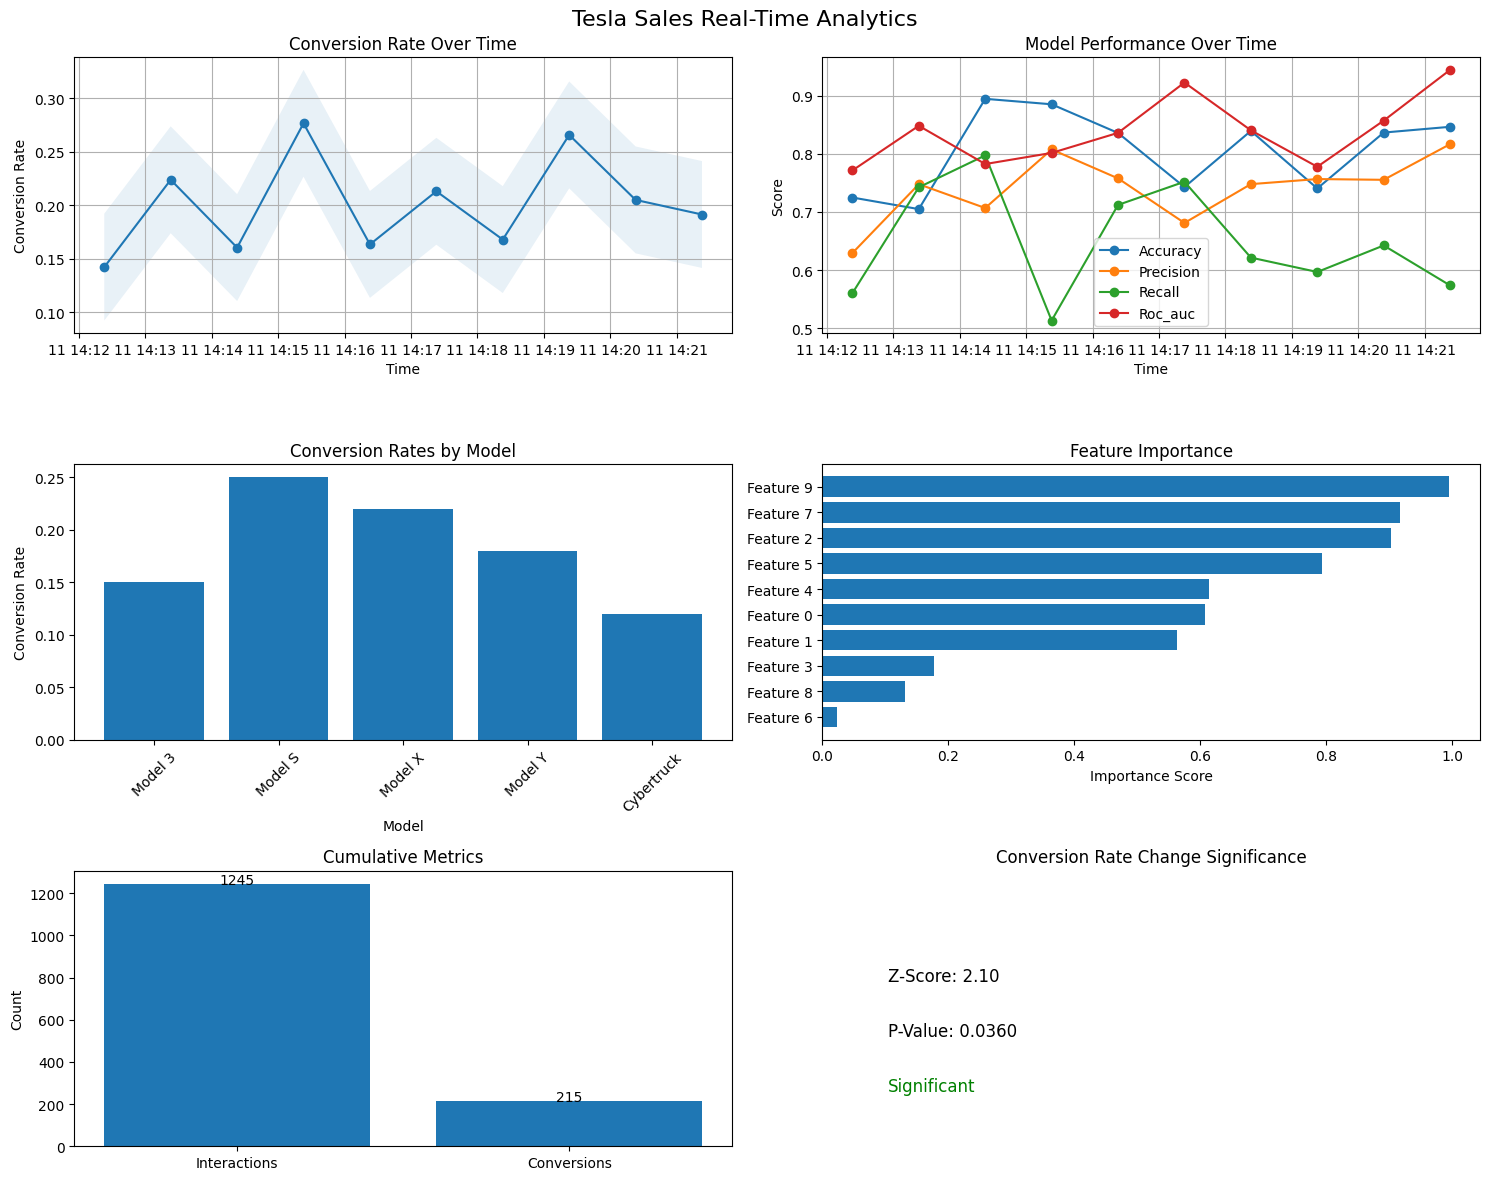

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from datetime import datetime, timedelta
from typing import Dict, Any, List

class TeslaAnalyticsDashboard:


    def __init__(self):
        self.fig, self.axes = plt.subplots(3, 2, figsize=(15, 12))
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        self.fig.suptitle("Tesla Sales Real-Time Analytics", fontsize=16)

    def update_dashboard(self, stats: Dict[str, Any],
                        metrics: Dict[str, float],
                        feature_importances: Dict[Any, List[float]]) -> None:
        clear_output(wait=True)

        ax = self.axes[0, 0]
        ax.clear()
        if len(stats.get("timestamps", [])) > 0:
            ax.plot(stats["timestamps"], stats["conversion_rates"],
                    label="Conversion Rate", marker="o")
            ax.set_title("Conversion Rate Over Time")
            ax.set_xlabel("Time")
            ax.set_ylabel("Conversion Rate")
            ax.grid(True)


            if "confidence_interval" in stats and len(stats["confidence_interval"]) == len(stats["timestamps"]):
                ci_low, ci_high = zip(*stats["confidence_interval"])
                ax.fill_between(stats["timestamps"], ci_low, ci_high, alpha=0.1)
            elif "confidence_interval" in stats and len(stats["confidence_interval"]) > 0:
                 logging.warning("Confidence interval data does not match timestamps length.")


        ax = self.axes[0, 1]
        ax.clear()
        if metrics and len(metrics.get("timestamps", [])) > 0:
            metric_names = ["accuracy", "precision", "recall", "roc_auc"]
            for metric in metric_names:
                if metric in metrics and len(metrics.get(metric, [])) > 0 and len(metrics[metric]) == len(metrics["timestamps"]):
                    ax.plot(metrics["timestamps"], metrics[metric],
                            label=metric.capitalize(), marker="o")
            ax.set_title("Model Performance Over Time")
            ax.set_xlabel("Time")
            ax.set_ylabel("Score")
            ax.legend()
            ax.grid(True)

        ax = self.axes[1, 0]
        ax.clear()
        if "model_conversion_rates" in stats and stats.get("model_conversion_rates", {}):
            models = list(stats["model_conversion_rates"].keys())
            rates = list(stats["model_conversion_rates"].values())
            ax.bar(models, rates)
            ax.set_title("Conversion Rates by Model")
            ax.set_xlabel("Model")
            ax.set_ylabel("Conversion Rate")
            ax.tick_params(axis="x", rotation=45)

        ax = self.axes[1, 1]
        ax.clear()
        if feature_importances and feature_importances.keys():
            latest_timestamp = max(feature_importances.keys())
            importances = feature_importances[latest_timestamp]


            if importances is not None:
                 feature_names = [f"Feature {i}" for i in range(len(importances))]

                 sorted_idx = np.argsort(importances)
                 ax.barh(np.array(feature_names)[sorted_idx], np.array(importances)[sorted_idx])
                 ax.set_title("Feature Importance")
                 ax.set_xlabel("Importance Score")


        ax = self.axes[2, 0]
        ax.clear()
        if "cumulative_stats" in stats and stats.get("cumulative_stats", {}):
            cum_stats = stats["cumulative_stats"]
            labels = ["Interactions", "Conversions"]
            values = [cum_stats.get("total_interactions", 0), cum_stats.get("total_conversions", 0)]

            ax.bar(labels, values)
            ax.set_title("Cumulative Metrics")
            ax.set_ylabel("Count")
            for i, v in enumerate(values):
                ax.text(i, v + 0.1, str(v), ha="center")

        ax = self.axes[2, 1]
        ax.clear()
        if "z_score" in stats and "p_value" in stats:
            z_score = stats.get("z_score", 0.0)
            p_value = stats.get("p_value", 1.0)

            ax.text(0.1, 0.6, f"Z-Score: {z_score:.2f}", fontsize=12)
            ax.text(0.1, 0.4, f"P-Value: {p_value:.4f}", fontsize=12)
            ax.text(0.1, 0.2,
                   "Significant" if p_value < config["analysis"].CONFIDENCE_LEVEL else "Not Significant",
                   fontsize=12,
                   color="green" if p_value < config["analysis"].CONFIDENCE_LEVEL else "red")
            ax.set_title("Conversion Rate Change Significance")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    def animate(self, frame: int, stats_generator, metrics_generator,
                feature_generator) -> None:
        """Animation function for real-time updates"""
        stats = next(stats_generator)
        metrics = next(metrics_generator)
        features = next(feature_generator)
        self.update_dashboard(stats, metrics, features)

if __name__ == "__main__":
    dashboard = TeslaAnalyticsDashboard()


    num_samples = 10
    sample_timestamps = [datetime.now() - timedelta(minutes=i) for i in range(num_samples, 0, -1)]
    sample_conversion_rates = np.random.uniform(0.1, 0.3, num_samples)
    sample_confidence_intervals = [(r - 0.05, r + 0.05) for r in sample_conversion_rates]


    sample_stats = {
        "timestamps": sample_timestamps,
        "conversion_rates": sample_conversion_rates.tolist(),
        "confidence_interval": sample_confidence_intervals,
        "model_conversion_rates": {
            "Model 3": 0.15,
            "Model S": 0.25,
            "Model X": 0.22,
            "Model Y": 0.18,
             "Cybertruck": 0.12
        },
        "z_score": 2.1,
        "p_value": 0.036,
        "cumulative_stats": {
            "total_interactions": 1245,
            "total_conversions": 215
        }
    }

    sample_metrics = {
        "accuracy": np.random.uniform(0.7, 0.9, num_samples).tolist(),
        "precision": np.random.uniform(0.6, 0.85, num_samples).tolist(),
        "recall": np.random.uniform(0.5, 0.8, num_samples).tolist(),
        "roc_auc": np.random.uniform(0.7, 0.95, num_samples).tolist(),
        "timestamps": sample_timestamps
    }

    sample_features = {
        datetime.now(): np.random.uniform(0, 1, 10).tolist()
    }


    if 'config' not in globals():
        from dataclasses import dataclass
        @dataclass
        class AnalysisConfig:
            CONFIDENCE_LEVEL: float = 0.95
            CONVERSION_RATE_WINDOW: int = 50
            STAT_TEST_WINDOW: int = 200
        config = {"analysis": AnalysisConfig()}
        print("Using dummy config for example usage.")


    dashboard.update_dashboard(sample_stats, sample_metrics, sample_features)

In [ ]:
import time
from datetime import datetime
from typing import Dict, Any, Optional
from queue import Queue
from threading import Thread, Lock
import pandas as pd
import numpy as np
import logging

class TeslaSalesAnalyticsApp:
    """
    Enhanced main application class with better error handling and monitoring.
    Key improvements:
    1. Thread-safe data handling
    2. Detailed progress monitoring
    3. Graceful shutdown
    4. Better dashboard updates
    """

    def __init__(self):
        self.data_stream = TeslaDataStream(stream_rate=config["data"].STREAM_RATE)
        self.data_processor = DataProcessor()
        self.model = TeslaConversionModel(model_type=config["model"].MODEL_TYPE)
        self.dashboard = TeslaAnalyticsDashboard()

        self.data_window = []
        self.data_queue = Queue(maxsize=1000)  # Prevent memory overflow
        self.stats_history = []
        self.metrics_history = []
        self.feature_history = {}

        # Thread control
        self.running = False
        self.lock = Lock()  # For thread-safe operations

        # Monitoring
        self.total_processed = 0
        self.last_update = time.time()

    def _stream_data(self) -> None:
        """Enhanced data streaming with monitoring"""
        try:
            record_count = 0
            while self.running:
                try:
                    record = next(self.data_stream.stream_data())
                    if record:
                        self.data_queue.put(("data", record))
                        record_count += 1

                        # Periodic status updates
                        if record_count % 50 == 0:
                            with self.lock:
                                print(f"📥 Streamed {record_count} records | Queue size: {self.data_queue.qsize()}")
                except StopIteration:
                    break
                except Exception as e:
                    logging.error(f"Stream error: {str(e)}")
                    time.sleep(1)  # Prevent tight loop on errors

            print(f"Data stream completed. Total records: {record_count}")
        except Exception as e:
            logging.critical(f"Stream thread crashed: {str(e)}")

    def _process_window(self) -> Optional[Dict[str, Any]]:
        """Enhanced window processing with validation"""
        try:
            with self.lock:
                if len(self.data_window) < config["data"].WINDOW_SIZE:
                    return None

                window_df = pd.DataFrame(self.data_window)

            # Process the window
            X_processed, y, stats = self.data_processor.process_window(window_df)

            if X_processed is None or y is None or len(y) == 0:
                print("⚠️ Empty processing results - skipping update")
                return None

            # Update model
            if not hasattr(self.model.model, "coef_") and not hasattr(self.model.model, "feature_importances_"):
                self.model.partial_fit(X_processed, y.values.ravel(), classes=np.array([0, 1]))
            else:
                self.model.partial_fit(X_processed, y.values.ravel())

            # Calculate metrics if we have both classes
            metrics = {}
            if len(np.unique(y)) > 1:
                metrics = self.model.update_metrics(X_processed, y.values.ravel(), datetime.now())
            else:
                metrics = {"timestamp": datetime.now()}

            # Update histories
            with self.lock:
                self.stats_history.append(stats)
                if metrics:
                    self.metrics_history.append(metrics)
                if self.model.feature_importances:
                    latest = max(self.model.feature_importances.keys())
                    self.feature_history[latest] = self.model.feature_importances[latest]

                self.total_processed += len(window_df)
                self.data_window = []  # Clear window

            return {
                "stats": stats,
                "metrics": self._compile_metrics(),
                "features": self.feature_history
            }

        except Exception as e:
            logging.error(f"Window processing failed: {str(e)}")
            return None

    def run(self) -> None:
        """Main execution loop with proper resource management"""
        print("🚀 Starting Tesla Sales Analytics System")
        print(f"Configuration: {config['data'].WINDOW_SIZE} records/window | {config['data'].STREAM_RATE} records/sec")

        self.running = True
        stream_thread = Thread(target=self._stream_data, daemon=True)
        stream_thread.start()

        try:
            last_dashboard_update = 0
            while self.running:
                # Process incoming data
                processed_count = 0
                while not self.data_queue.empty() and processed_count < 100:
                    try:
                        _, record = self.data_queue.get_nowait()
                        with self.lock:
                            self.data_window.append(record)
                        processed_count += 1
                    except:
                        break

                # Process window if ready
                result = self._process_window()

                # Update dashboard periodically (every 2 sec or when window processed)
                current_time = time.time()
                if result or (current_time - last_dashboard_update > 2):
                    self._update_dashboard(result)
                    last_dashboard_update = current_time

                # Status monitoring
                if current_time - self.last_update > 5:
                    self._print_status()
                    self.last_update = current_time

                time.sleep(0.05)  # Reduced sleep for more responsive UI

        except KeyboardInterrupt:
            print("\n🛑 Shutdown requested...")
        finally:
            self.running = False
            stream_thread.join()
            self._shutdown()

    def _update_dashboard(self, result: Optional[Dict[str, Any]]) -> None:
        """Safe dashboard updating"""
        try:
            if result:
                stats = {
                    "timestamps": [s.get("timestamp") for s in self.stats_history[-10:]],
                    "conversion_rates": [s.get("conversion_rate", 0) for s in self.stats_history[-10:]],
                    "cumulative_stats": self.data_processor.cumulative_stats,
                    "model_conversion_rates": {
                        model: (self.data_processor.cumulative_stats["conversion_counts"].get(model, 0) /
                               max(1, self.data_processor.cumulative_stats["model_counts"].get(model, 0)))
                        for model in self.data_processor.cumulative_stats["model_counts"]
                    }
                }

                self.dashboard.update_dashboard(
                    stats,
                    result["metrics"],
                    result["features"]
                )
            else:
                # Minimal update to keep dashboard alive
                self.dashboard.update_dashboard(
                    {"timestamps": [], "conversion_rates": []},
                    {"timestamps": []},
                    {}
                )
        except Exception as e:
            logging.error(f"Dashboard update failed: {str(e)}")

    def _print_status(self) -> None:
        """System status monitoring"""
        with self.lock:
            status = (
                f"\n📊 Status | Processed: {self.total_processed} | "
                f"Window: {len(self.data_window)}/{config['data'].WINDOW_SIZE} | "
                f"Queue: {self.data_queue.qsize()}"
            )
            if self.stats_history:
                last_rate = self.stats_history[-1].get("conversion_rate", 0)
                status += f" | Conv Rate: {last_rate:.1%}"
            print(status)

    def _shutdown(self) -> None:
        """Graceful shutdown procedure"""
        print("\n💾 Saving model and cleaning up...")
        try:
            model_path = f"{config['paths'].MODEL_PATH}/tesla_model_{datetime.now().strftime('%Y%m%d_%H%M')}.joblib"
            self.model.save_model(model_path)
            print(f"Model saved to {model_path}")
        except Exception as e:
            print(f"⚠️ Failed to save model: {str(e)}")

        print("✅ System shutdown complete")


if __name__ == "__main__":
    # Verify all components exist
    required = {'DataProcessor', 'TeslaDataStream', 'TeslaConversionModel',
               'TeslaAnalyticsDashboard', 'config'}
    missing = required - set(globals())

    if not missing:
        app = TeslaSalesAnalyticsApp()
        app.run()
    else:
        print(f"❌ Missing components: {', '.join(missing)}")

        print("Testing data stream:")
for i, record in enumerate(TeslaDataStream().stream_data()):
    print(record)
    if i > 2: break

<Figure size 640x480 with 0 Axes>


📊 Status | Processed: 0 | Window: 829800/100 | Queue: 1000
